In [41]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
from einops import rearrange
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plte
# from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffuse.diffusion_utilities import *
from diffuse.models.context_unet import ContextUnet
import os
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
# from diffuse.noise_scheduler import NoiseScheduler2
from diffuse.utils import pil_image_grid
from PIL import Image
from diffuse.diffusion_utilities import unorm
from einops import rearrange
from diffuse.noise_scheduler import NoiseScheduler2
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setting Things Up

In [42]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

s = NoiseScheduler2(n_timesteps=timesteps, beta1=beta1, beta2=beta2)

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

In [43]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# Training

In [44]:
# load dataset and construct optimizer
dataset = CustomDataset("../data/sprites_1788_16x16.npy", "../data/sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [45]:
# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps, (x.shape[0],)).to(device)
        x_pert = s.perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


  0%|                                                                                                                                                                                                                      | 0/894 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10ef2f1a0>
Traceback (most recent call last):
  File "/Users/egafni/projects/Diffusion/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    def __del__(self):

  File "/Users/egafni/projects/Diffusion/.venv/lib/python3.11/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 76560) is killed by signal: Interrupt: 2. 
  0%|                                                                                                                                                                                                                      | 0/894

KeyboardInterrupt: 

# Sampling

#### View Epoch 0 

In [46]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_0.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


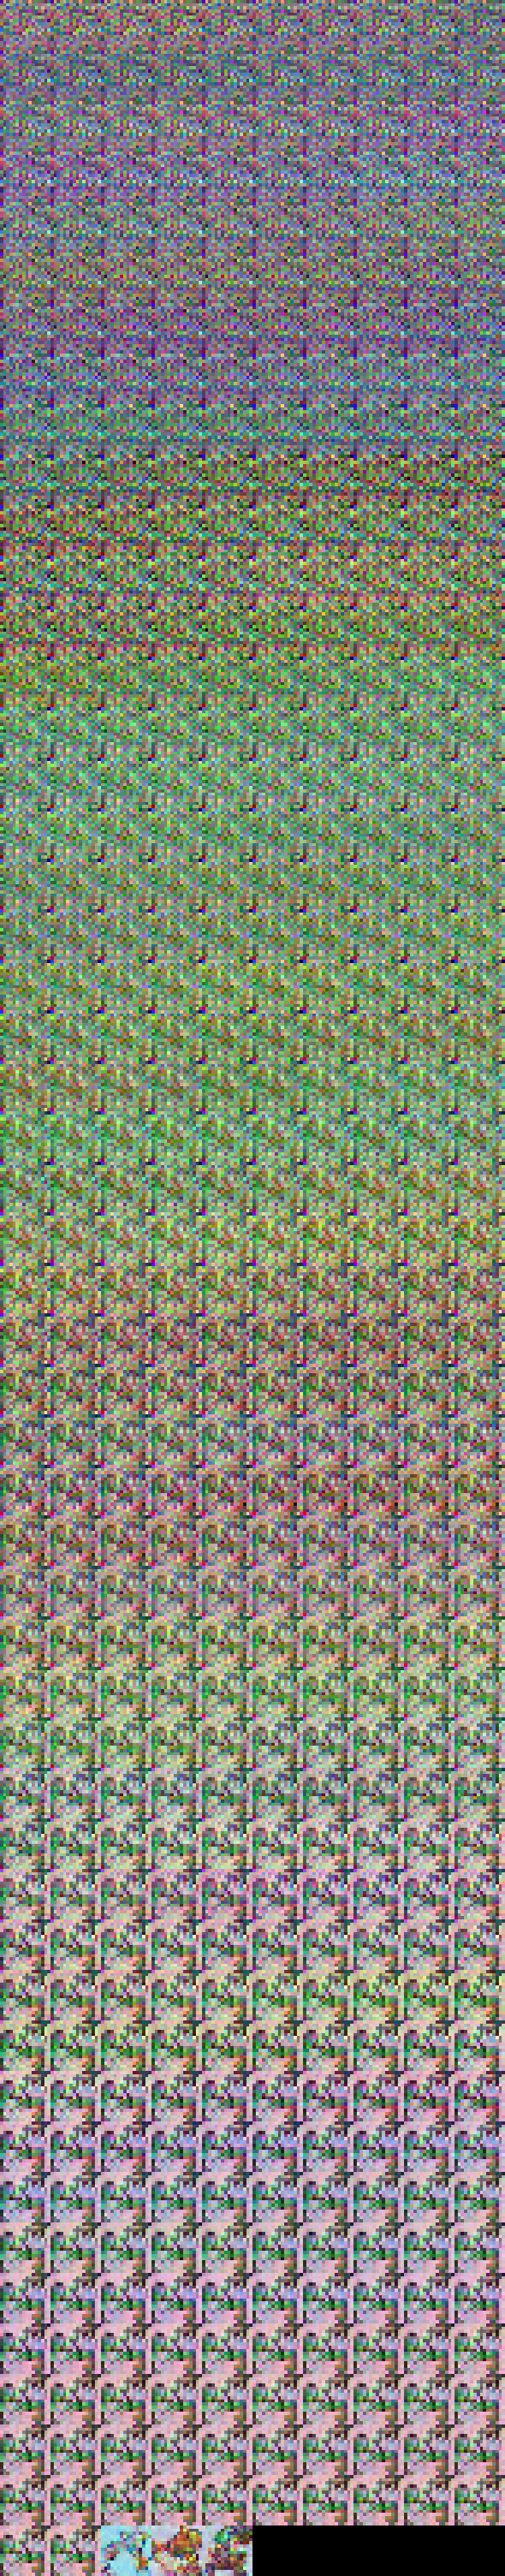

In [48]:
traj = s.sample(nn_model,(4,)+tuple(x.shape[1:])).numpy()
z = unorm(rearrange(traj,'t b c h w -> b t h w c'))
pil_image_grid(np.concatenate([z[0,],z[:,-1]]), 10, (75,75))

#### View Epoch 4 

In [61]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_4.pth", map_location=device))
nn_model.eval()
traj = s.sample(nn_model,(4,)+tuple(x.shape[1:])).numpy()

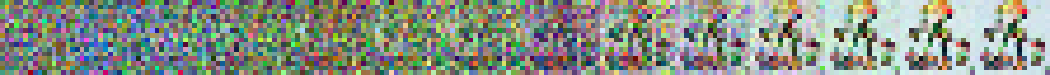

In [59]:
z = unorm(rearrange(traj,'t b c h w -> b t h w c'))
pil_image_grid(z[0], cols=14, resize=(75,75),max_n=14)

#### View Epoch 8

In [29]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_8.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


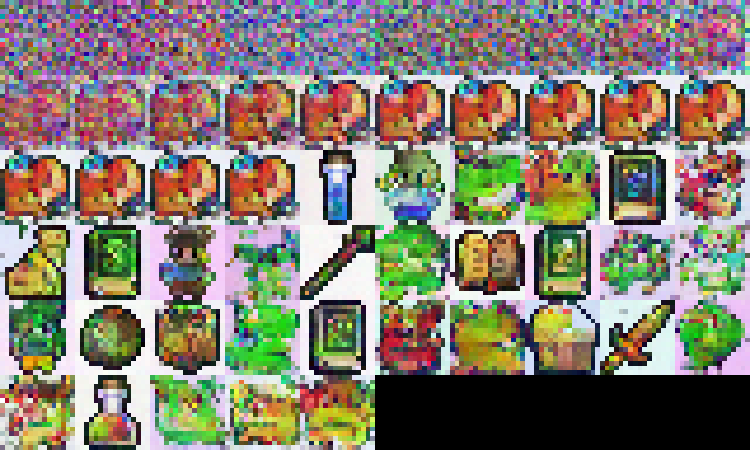

In [30]:
samples, intermediate_ddpm = sample_ddpm(32)
z = rearrange(intermediate_ddpm,'t b c h w -> b t h w c')
z = unorm(z)
pil_image_grid(np.concatenate([z[0,],z[:,-1]]), 10, (75,75))

#### View Epoch 31 

In [64]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_4.pth", map_location=device))
nn_model.eval()
traj = s.sample(nn_model,(4,)+tuple(x.shape[1:])).numpy()

In [83]:
# plt.imshow(z[0][-1])

In [ ]:
z = unorm(rearrange(traj,'t b c h w -> b t h w c'))
pil_image_grid(z[0], cols=14, resize=(75,75),max_n=14)

In [73]:
z = unorm(rearrange(traj,'t b c h w -> b t h w c'))
pil_image_grid(z[4], cols=14, resize=(75,75),max_n=14)

IndexError: index 4 is out of bounds for axis 0 with size 4

In [92]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32)
animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>